# Quantum Error Mitigation via Linear Depth Verifier Circuits

In [1]:
from qiskit.circuit.library import MCXGate
from qiskit import QuantumCircuit, execute, transpile, Aer
from qiskit.providers.fake_provider import FakeMumbai
from qiskit.extensions import UnitaryGate
import qiskit_aer.noise as noise
from scipy.linalg import diagsvd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np

Let's quickly test where the crossover might be.

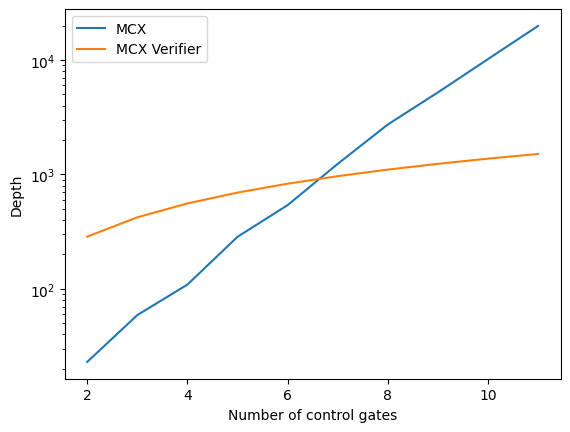

[23, 59, 109, 285, 539, 1237, 2730, 5210, 10188, 19853]
[286, 422, 558, 694, 830, 966, 1102, 1238, 1374, 1510]


In [2]:
square_grid = [
    [0,1], [1,2], [2,3],
    [0,4], [1,5], [2,6], [3,7],
    [4,5], [5,6], [6,7],
    [4,8], [5,9], [6,10], [7,11],
    [8,9], [9,10], [10,11],
    [8,12], [9,13], [10,14], [11,15],
    [12,13], [13,14], [14,15]
]

depths = []
verifier_depths = []
for n in range(2, 12):
    qc = QuantumCircuit(n+1)
    gate = MCXGate(n)
    qc.append(gate, range(n+1))
    trans = transpile(qc, basis_gates=["cx", "u3"], coupling_map=square_grid)
    depths.append(trans.depth())
    verifier_depths.append((n+1)*136 - 122)

plt.plot(range(2,12), depths)
plt.plot(range(2,12), verifier_depths)
plt.yscale("log")
plt.xlabel("Number of control gates")
plt.ylabel("Depth")
plt.legend(["MCX", "MCX Verifier"])
plt.show()

print(depths)
print(verifier_depths)


The next cell just confirms the MPO structure of the MCX gate

In [3]:
id_gate = np.eye(2)
zero_gate = np.zeros((2,2))
projector_00 = np.array([[1,0],[0,0]])
projector_11 = np.array([[0,0],[0,1]])
control_gate_3 = np.array([projector_00, projector_11])
control_gate_4 = np.array([[id_gate, zero_gate],[projector_00, projector_11]])
x_gate = np.array([[0,1],[1,0]])
x_gate_3 = np.array([id_gate, x_gate])

n = 2
tensors = [control_gate_3] + [control_gate_4] * (n-1) + [x_gate_3]

# Check that this is indeed MCX
o1 = np.einsum(tensors[0], [0,1,2], tensors[1], [0,3,4,5], [3,1,4,2,5])
o2 = np.einsum(o1, [0,1,2,3,4], tensors[2], [0,5,6], [1,2,5,3,4,6])
o3 = np.reshape(o2, (8,8))
# print(o3)


zero = np.array([1,0])
one = np.array([0,1])

for i in range(2**(n+1)):
    for j in range(2**(n+1)):
        input_bits = bin(i)[2:].zfill(n+1)
        output_bits = bin(j)[2:].zfill(n+1)

        input_states = []
        output_states = []

        for b in input_bits:
            if b == "0":
                input_states.append(zero)
            else:
                input_states.append(one)
        for b in output_bits:
            if b == "0":
                output_states.append(zero)
            else:
                output_states.append(one)
        
        tensor_1 = np.einsum(tensors[0], [0,1,2], output_states[0], [1], input_states[0], [2], [0])
        contracted_tensors = [tensor_1]

        for k in range(1, n):
            tensor = tensors[k]
            output_state = output_states[k]
            input_state = input_states[k]
            tensor_k = np.einsum(tensor, [0,1,2,3], output_state, [2], input_state, [3], [0,1])
            contracted_tensors.append(tensor_k)
        
        tensor_n = np.einsum(tensors[n], [0,1,2], output_states[n], [1], input_states[n], [2], [0])
        contracted_tensors.append(tensor_n)

        for k in range(n-1):
            top_tensor = contracted_tensors[k]
            bottom_tensor = contracted_tensors[k+1]
            contracted_tensors[k+1] = np.einsum(top_tensor, [0], bottom_tensor, [0,1], [1])
        
        output_val = np.einsum(contracted_tensors[n-1], [0], contracted_tensors[n], [0])
        # if output_val == 1.0:
            # print(input_bits, output_bits, output_val)

        if input_bits[:-1] == output_bits[:-1] and input_bits[:-1] == "1" * n and input_bits[-1] != output_bits[-1]:
            assert np.isclose(output_val, 1)
        elif input_bits == output_bits and input_bits[:-1] != "1" * n:
            assert np.isclose(output_val, 1)
        else:
            assert output_val != 1

We now perform an SVD sweep on the MCX MPO to obtain a verifier circuit structure.

In [13]:
def mcx_verifier(n):

    assert n >= 2, "There must be at least 2 control qubits."

    ##############
    # Definitions
    ##############
    
    id_gate = np.eye(2)
    zero_gate = np.zeros((2,2))
    projector_00 = np.array([[1,0],[0,0]])
    projector_11 = np.array([[0,0],[0,1]])
    control_gate_3 = np.array([projector_00, projector_11])
    control_gate_4 = np.array([[id_gate, zero_gate],[projector_00, projector_11]])
    x_gate = np.array([[0,1],[1,0]])
    x_gate_3 = np.array([id_gate, x_gate])

    ##############
    # SVD Sweep
    ##############

    final_tensors = []

    # Bond order: up, down, right, left

    tensor_1 = control_gate_3
    tensor_1 = np.reshape(tensor_1, (2,4))
    u1, s1, vh1 = np.linalg.svd(tensor_1, full_matrices=True)
    final_tensors.append(vh1)

    s1 = diagsvd(s1, 2,2)
    u1s1 = np.matmul(u1,s1)
    feed_in_matrix = u1s1

    for _ in range(1, n):
        tensor_idx = control_gate_4
        tensor_idx = np.einsum("abcd,ea->becd", tensor_idx, feed_in_matrix)
        tensor_idx = np.reshape(tensor_idx, (2,8))
        u_idx, s_idx, vh_idx = np.linalg.svd(tensor_idx, full_matrices=True)
        final_tensors.append(vh_idx)
        s_idx = diagsvd(s_idx, 2,2)
        u_idxs_idx = np.matmul(u_idx, s_idx)
        feed_in_matrix = u_idxs_idx

    tensor_last = x_gate_3 
    tensor_last = np.einsum("abc,da->dbc", tensor_last, feed_in_matrix)
    tensor_last = np.reshape(tensor_last, (1,8))
    u_last, s_last, vh_last = np.linalg.svd(tensor_last, full_matrices=True)
    final_tensors.append(vh_last)
    s_last = diagsvd(s_last,1,8)
    u_lasts_last = np.matmul(u_last, s_last)

    output_tensor = np.reshape(u_lasts_last, (8)).conjugate()

    return final_tensors, output_tensor

for num_ctrls in range(2, 21): 
    _, output = mcx_verifier(num_ctrls)
    print(num_ctrls, output[0], 2**((num_ctrls+1)/2))


2 -2.8284271247461903 2.8284271247461903
3 -4.0 4.0
4 -5.656854249492381 5.656854249492381
5 -7.999999999999999 8.0
6 -11.31370849898476 11.313708498984761
7 -15.999999999999998 16.0
8 -22.627416997969522 22.627416997969522
9 -32.0 32.0
10 -45.254833995939045 45.254833995939045
11 -63.99999999999999 64.0
12 -90.50966799187806 90.50966799187809
13 -127.99999999999997 128.0
14 -181.01933598375612 181.01933598375618
15 -255.99999999999994 256.0
16 -362.0386719675123 362.03867196751236
17 -512.0 512.0
18 -724.0773439350246 724.0773439350247
19 -1024.0 1024.0
20 -1448.1546878700494 1448.1546878700494


Now test the MCX verifier

In [5]:
n = 2
verifier_mcx, output_vec = mcx_verifier(n)

input_bits = []
output_bits = []
for i in range(2*(n+1)):
    if i % 2 == 0:
        output_bits.append(i)
    else:
        input_bits.append(i)

for i in range(2**(n+1)):
    for j in range(2**(n+1)):

        qc = QuantumCircuit(2*(n+1))

        input_bitstring = bin(i)[2:].zfill(n+1)
        output_bitstring = bin(j)[2:].zfill(n+1)

        for b_idx in range(len(input_bitstring)):
            b = input_bitstring[b_idx]
            if b == "1":
                qc.x(input_bits[b_idx])
        for b_idx in range(len(output_bitstring)):
            b = output_bitstring[b_idx]
            if b == "1":
                qc.x(output_bits[b_idx])

        for k in range(n+1):
            gate = verifier_mcx[k]
            qiskit_gate = UnitaryGate(gate)

            if k == 0:
                qc.append(qiskit_gate, [1,0])
            else:
                qc.append(qiskit_gate, [2*k+1, 2*k, 2*k-1])

        # print(qc)
        
        job = execute(qc, backend=Aer.get_backend("statevector_simulator"))
        output_val = np.array(job.result().get_statevector())[0]
        output_fidelity = 1 - 0.5 * np.abs(np.abs(1/(2**((n+1)/2)))**2 - np.abs(output_val)**2)
    
        # output_fidelity = np.sqrt(np.abs(np.inner(output_val, output_vec))**2)
        # print(input_bitstring, output_bitstring, output_fidelity)

        if input_bitstring[:-1] == output_bitstring[:-1] and input_bitstring[:-1] == "1" * n and input_bitstring[-1] != output_bitstring[-1]:
            assert np.isclose(output_fidelity, 1)
        elif input_bitstring == output_bitstring and input_bitstring[:-1] != "1" * n:
            assert np.isclose(output_fidelity, 1)
        else:
            assert output_fidelity != 1


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


Plot the crossover point.

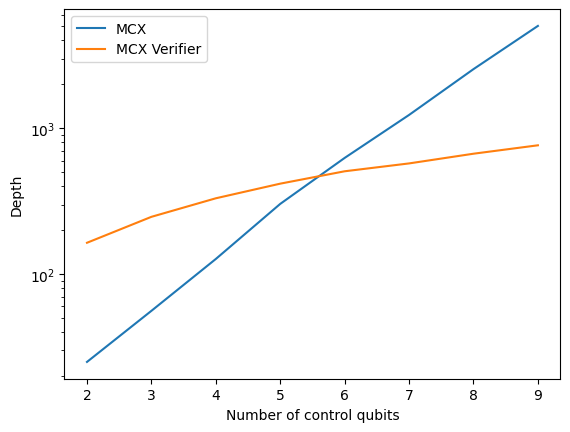

In [6]:
square_grid = [
    [0,1], [1,2], [2,3], [3,4],
    [0,5], [1,6], [2,7], [3,8], [4,9],
    [5,6], [6,7], [7,8], [8,9],
    [5,10], [6,11], [7,12], [8,13], [9,14],
    [10,11], [11,12], [12,13], [13,14],
    [10,15], [11,16], [12,17], [13,18], [14,19],
    [15,16], [16,17], [17,18], [18,19],
    [15,20], [16,21], [17,22], [18,23], [19,24],
    [20,21], [21,22], [22,23], [23,24]
]

verifier_depths = []
for n in range(2, 10):
    depths = []
    for _ in range(20):
        verifier_mcx, _ = mcx_verifier(n)

        qc = QuantumCircuit(2*(n+1))

        for k in range(n+1):
            gate = verifier_mcx[k]
            qiskit_gate = UnitaryGate(gate)

            if k == 0:
                qc.append(qiskit_gate, [1,0])
            else:
                qc.append(qiskit_gate, [2*k+1, 2*k, 2*k-1])
        
        trans = transpile(qc, basis_gates=["cx", "u3"], coupling_map=square_grid)
        depths.append(trans.depth())
    verifier_depths.append(round(np.mean(depths)))

depths = []
for n in range(2, 10):
    temp_depths = []
    for _ in range(20):
        qc = QuantumCircuit(n+1)
        gate = MCXGate(n)
        qc.append(gate, range(n+1))
        trans = transpile(qc, basis_gates=["cx", "u3"], coupling_map=square_grid)
        temp_depths.append(trans.depth())
    depths.append(round(np.mean(temp_depths)))

plt.plot(range(2,10), depths)
plt.plot(range(2,10), verifier_depths)
plt.yscale("log")
plt.xlabel("Number of control qubits")
plt.ylabel("Depth")
plt.legend(["MCX", "MCX Verifier"])
plt.show()

So with just 6 control bits, we can be confident that more errors are arising from the MCX gate than from the verifier circuit. At 8 or more control bits, error mitigation using the verifier circuit may become possible. Error mitigation will certainly be possible with 12 or more control bits. 

Let's test some error mitigation. We'll start with single qubit corrections and a greedy optimisation strategy.

In [7]:
# Build noise model
backend = FakeMumbai()
noise_model = noise.NoiseModel.from_backend(backend, gate_error=True, readout_error=False, thermal_relaxation=True)

In [8]:
def mcx_fidelity(parameters):
    num_control_bits = 9
    qc = QuantumCircuit(2*(num_control_bits+1))

    input_bits = []
    output_bits = []
    for i in range(2*(num_control_bits+1)):
        if i % 2 == 0:
            output_bits.append(i)
        else:
            input_bits.append(i)

    # Initialise inputs


    # Add mcx gate
    mcx_gate = MCXGate(num_control_bits)
    qc.append(mcx_gate, output_bits)

    # Error mitigation layer
    for k in range(num_control_bits+1):
        qc.rx(parameters[3*k], output_bits[k])
        qc.ry(parameters[3*k+1], output_bits[k])
        qc.rz(parameters[3*k+2], output_bits[k])

    # Add verifier circuit
    verifier_mcx, output_vec = mcx_verifier(num_control_bits)

    for k in range(num_control_bits+1):
        gate = verifier_mcx[k]
        qiskit_gate = UnitaryGate(gate)

        if k == 0:
            qc.append(qiskit_gate, [1,0])
        else:
            qc.append(qiskit_gate, [2*k+1, 2*k, 2*k-1])

    # Execute circuit
    qc.measure_all()

    trans = transpile(qc, backend=FakeMumbai())
    job = execute(trans, backend=Aer.get_backend("qasm_simulator"), noise_model=noise_model, shots=1000)

    # Get post-selected counts and compute fidelity
    counts = job.result().get_counts()
    all_0s = "0" * (2*(num_control_bits+1))

    all_0s_counts = counts[all_0s] if all_0s in list(counts.keys()) else 0
    all_0s_weight = np.sqrt(all_0s_counts / sum(list(counts.values())))
    output_fidelity = 1 - 0.5 * np.abs(np.abs(all_0s_weight)**2 - np.abs(1/(2**(num_control_bits))**2))

    return output_fidelity

# print(mcx_fidelity([0.0] * 15))

In [9]:
# params = [0.0] * 15 
# fidelity = 0.0
# while fidelity < 0.99:
#     for i in range(len(params)):
#         def optimize_func(xi):
#             input_params = params[:i] + [float(xi)] + params[i+1:]
#             return 1 - mcx_fidelity(input_params)
        
#         result = minimize(optimize_func, params[i])
#         if result.success:
#             fitted_param = result.x
#             params[i] = float(fitted_param[0])
        
#         fidelity = mcx_fidelity(params)
#         print(fidelity)

# print(params)

/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, sign

0.98775


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.99475


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, sign

0.99325


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.98675


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.99475


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.99725


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.98225
0.99025


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.98225


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.99075


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.98325


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, sign

0.98075


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.98875


/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/homebrew/lib/python3.10/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


0.98375
0.99325
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.844745031217468e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
